## Incremental learning with River

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import mahalanobis
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [3]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [4]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [5]:
# feature selection (see previous part -- xgboost binary)
subset_indices =  [191, 374, 328, 673]

In [6]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

### Recreate original dataset

In [7]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [8]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [9]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [10]:
data_all_top = data_all[:, subset_indices] 
healthy_data = data_all_top[y_all == 0]
damage_data = data_all_top[y_all == 1]
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [11]:
# for occ labels are defined differently
damage_labels  = -1*np.ones(damage_data.shape[0])
healthy_labels =    np.ones(healthy_data.shape[0])

In [12]:
def fill_between_plot(x_range, average_obs, std_obs, label, title):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    for idx, (avg_obs, std_ob) in enumerate(zip(average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color = colors[idx], label=label)
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx], alpha=0.5, label='1 std dev')
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(label)
    plt.legend()
    plt.show()

In [13]:
def fill_between_plot_diffx(x_ranges, average_obs, std_obs, label, title, labely):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    
    # Ensure that x_ranges, average_obs, and std_obs have the same length
    if not (len(x_ranges) == len(average_obs) == len(std_obs)):
        raise ValueError("Length of x_ranges, average_obs, and std_obs must be the same")

    for idx, (x_range, avg_obs, std_ob) in enumerate(zip(x_ranges, average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color=colors[idx % len(colors)], label=f'{label[idx]}')
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx % len(colors)], alpha=0.5, label='1 std dev')
    
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(labely)
    plt.legend()
    plt.show()

### Test and training dataset

In [14]:
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [15]:
random.seed(42)
test_size = 0.25
np.random.seed(42)
healthy_idx = np.concatenate([[i*36 + np.random.choice(36, size=int(36*(1-test_size)), replace=False)] for i in range(8)], axis=1)[0]
print(healthy_idx)
healthy_train = healthy_data[np.sort(healthy_idx), :]
healthy_test = healthy_data[np.sort(np.array([i for i in range(healthy_data.shape[0]) if i not in healthy_idx])), :]

dam_test = damage_data
healthy_train.shape, dam_test.shape, healthy_test.shape

[ 35  13  26  30  16  31  21  12   8  17   9  34   0   4  29  15  19   5
  11   1  24   2  33   3  32  23  27  51  52  40  45  64  57  46  41  54
  48  61  58  65  36  62  71  59  43  47  67  50  55  37  69  68  66  49
  73  82  76 104  77  74 102 106  95  83  78  88  72  93  90  91  80  96
  99 107  84 100  92  98  94 103  79 118 136 111 127 128 120 113 139 143
 117 134 125 124 121 122 132 126 141 129 138 137 110 142 131 133 130 123
 170 174 164 146 151 159 144 161 165 152 177 163 169 157 168 160 155 149
 167 153 145 162 172 171 176 154 158 202 213 183 190 195 200 215 205 212
 197 208 207 214 181 186 193 204 211 196 199 210 201 194 203 191 189 198
 228 231 235 250 222 223 225 229 240 218 233 237 244 224 249 230 239 251
 246 220 242 232 226 243 219 238 221 277 275 274 255 257 273 272 266 282
 285 264 256 263 265 276 253 268 287 267 279 254 261 278 262 281 280 269]


((216, 4), (324, 4), (72, 4))

In [16]:
test_data = np.vstack([healthy_test, dam_test])
test_labels = np.repeat([1, -1], [healthy_test.shape[0], dam_test.shape[0]]).astype(int)

train_data = healthy_train
train_labels = np.full(train_data.shape[0], 1).astype(int)

In [17]:
pca = PCA(n_components=3)
sc = StandardScaler()

sc.fit(healthy_data[0:36])
pca.fit(healthy_data[0:36])

train_data = sc.transform(train_data)
train_data = pca.transform(train_data)

test_data = sc.transform(test_data)
test_data = pca.transform(test_data)

train_data.shape, test_data.shape, pca.explained_variance_, pca.explained_variance_ratio_

((216, 3),
 (396, 3),
 array([1.49010295, 0.19344821, 0.09351647]),
 array([0.80329501, 0.1042854 , 0.05041351]))

In [18]:
damage_data.shape

(324, 4)

## Visualization (static)

### Time color-coded - static

In [222]:
import matplotlib
matplotlib.use('Qt5Agg')
data_plot = np.vstack([healthy_data, damage_data])
data_plot = pca.transform(data_plot)

plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 1], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

(612, 4)


In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 1], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

### Healthy vs damaged scatter plots - static

In [153]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 1], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 1], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [155]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 1],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [223]:
np.save("data_plot.npy", data_plot)

### Healthy vs damaged - animated

In [233]:
import matplotlib.animation as animation
matplotlib.use('Qt5Agg')  # 'Qt5Agg', 'Qt4Agg', 'GTK3Agg', 'WXAgg'

data_plot = np.load("data_plot.npy")
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 1], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc2animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

In [234]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


In [232]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 2')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 1], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc2pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


In [238]:
corr = np.corrcoef(data_all_top, rowvar=False)
print(corr.shape)

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

(4, 4)


In [18]:
param_grid_occ_svm = {
    'nu': [0.01, 0.1, 0.2], 
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-2, 1e-1],
    'kernel': ['rbf']
} # rbf by default

### Story
Train OCC on first health scenario, then data comes one by one. Each data point that arrives is added to the support of the OCC. The OCC detects weather each new arriving point is anomalous or not. After accumulation of all healthy points into the support occurs, we test on all damage data to see whether it will report healthy or damaged. Note, to be realistic the support should be implemented incrementally, i.e. naively storing all arriving instances is not realistic.   

In [458]:
healthy_data_top = pca.transform(sc.transform(healthy_data))
damage_data_top  = pca.transform(sc.transform(damage_data))

# last half of 7 and first half of 8 should be val
healthy_data_top_val   = healthy_data_top[int(-72 + (36/2)):-18]
healthy_data_top_train = np.vstack((healthy_data_top[:int(-72 + (36/2))], healthy_data_top[-18:]))

healthy_data.shape, damage_data.shape, healthy_data_top.shape, damage_data_top.shape, healthy_data_top_train.shape, healthy_data_top_val.shape

((288, 4), (324, 4), (288, 3), (324, 3), (252, 3), (36, 3))

### Base stream learner

In [459]:
class StreamLearning:
    def __init__(self, h_data, d_data, clf):
        self.h_data = h_data # healthy state data
        self.d_data = d_data # damage state data
        self.clf = clf       # the OCC
        self.ctr = 36        # current healthy instance (first health scen) 
        self.an_inst = []    # stores the indices of the anomalous instances
        self.d_preds = []
        self.h_preds = []
        self.d_pred_proba = []
        self.h_pred_proba = []

    def support_include(self): # include into the support
        self.clf.update(self.h_data[self.ctr])
        self.ctr += 1

    def is_cur_anomaly(self):
        cur_inst = self.h_data[self.ctr]
        self.h_pred_proba.append(self.clf.predict_proba(cur_inst)[0])
        if self.clf.predict(cur_inst)[0] < 0:
            self.an_inst.append(self.ctr)

    def final_evaluation(self):
        print("eval dam")
        self.d_preds = self.clf.predict(self.d_data)
        print("eval healthy")
        self.h_preds = self.clf.predict(self.h_data)
        self.d_pred_proba = self.clf.predict_proba(self.d_data)

    def loop(self):
        n_iters = self.h_data.shape[0] - self.ctr
        # initialize 
        for i in range(self.ctr):
            self.clf.update(self.h_data[i])
        
        # simulate data intake
        for i in range(n_iters):
            self.is_cur_anomaly()
            self.support_include()
        self.final_evaluation()

### Method 0: Gaussian ellipsoid

In [460]:
from scipy.spatial import distance
from scipy.stats import chi2

class IncrementalGaussianFitter:
    def __init__(self):
        self.mean = np.array([0.0, 0.0, 0.0])
        self.covariance = np.eye(3)
        self.count = 0

    def update(self, new_point):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (new_point - self.mean) / self.count
        self.covariance = ((self.count - 1) * self.covariance + 
                           np.outer(new_point - self.mean, new_point - self.mean)) / self.count

    def get_mean(self):
        return self.mean

    def get_covariance(self):
        return self.covariance
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        return (mahalanobis_distances ** 2) - threshold # the higher the more likely an anomaly
    
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        result = mahalanobis_distances ** 2 <= threshold
        result = [2*int(el) - 1  for el in result]
        return result

In [461]:
slg = StreamLearning(healthy_data_top_train, damage_data_top, IncrementalGaussianFitter())
slg.loop()

eval dam
eval healthy


In [71]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode

eigenvalues, eigenvectors = np.linalg.eig(slg.clf.covariance)

# Create a grid for the ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
y = 2*np.sqrt(eigenvalues[0])*np.outer(np.cos(u), np.sin(v)) # two standard deviation to cover 95% of the confidence 
x = 2*np.sqrt(eigenvalues[1])*np.outer(np.sin(u), np.sin(v))
z = 2*np.sqrt(eigenvalues[2])*np.outer(np.ones(np.size(u)), np.cos(v))

# Scale each point by the square root of the corresponding eigenvalue (standard deviation)
for i in range(len(x)):
    for j in range(len(x)):
        [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], eigenvectors) + slg.clf.mean

# Create a 3D plot
fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
ax.axis('auto')

# Plot the original points
ax.scatter(healthy_data_top[:, 0], healthy_data_top[:, 1], healthy_data_top[:, 2], color='blue', marker='o')
ax.scatter(damage_data_top[:, 0], damage_data_top[:, 1], damage_data_top[:, 2], color='red', marker='o')
ax.set_xlim((-4, 1))
ax.set_ylim((-1, 6))
ax.set_zlim((-5, 3))

# Plot the ellipsoid
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

# Plot principal axes as line segments
for i in range(3):
    axis_start = np.zeros(3) + slg.clf.mean
    axis_end =  eigenvectors[:, i] * np.sqrt(eigenvalues[i])*2 + slg.clf.mean  # Scale factor for visibility
    ax.plot([axis_start[0], axis_end[0]], [axis_start[1], axis_end[1]], [axis_start[2], axis_end[2]], color='green', linewidth=2)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# save pc1pc2slg, pc2pc3slg, pc1pc3slg
plt.show()

In [462]:
np.sum(np.array(slg.d_preds) < 0), np.sum(np.array(slg.h_preds) > 0), len(slg.d_preds), len(slg.h_preds)

(301, 230, 324, 252)

In [494]:
import seaborn as sns
%matplotlib inline
def plot_anom(sl :StreamLearning, title):
    sns.reset_defaults()
    sns.reset_orig()

    plt.figure(figsize=(15, 6))
    nbr_epochs = healthy_data_top_train.shape[0] - 36 + damage_data_top.shape[0]
    print(nbr_epochs)

    an_scores = np.hstack((sl.h_pred_proba, sl.d_pred_proba)).reshape(-1, 1)
    print(len(range(0, nbr_epochs+1, 36)))
    for i in range(0, nbr_epochs+1, 36):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    # scale and plot the bars
    sc = StandardScaler()
    obs = np.arange(len(an_scores))
    std_entropies = sc.fit_transform(an_scores).flatten()
    plt.axvspan(36*6, 36*15, color='yellow', alpha=0.08)
    plt.bar(obs, std_entropies)
    plt.ylim(0, 1.15*max(std_entropies))

    plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
    plt.ylabel('Standardized anomaly score')
    plt.title(title)
    text_pos = [i+18 for i in range(0, nbr_epochs, 36)]
    
    offset = 0
    for idx, pos in enumerate(text_pos):
        str_capt =  f'DS {idx+2+offset}'
        if idx+2 == 7:
            str_capt = f'DS 7/8 (T)'
            offset = 1
        plt.text(pos, max(std_entropies)*1.1, str_capt, ha='center', color='red')

    plt.show()

540
16


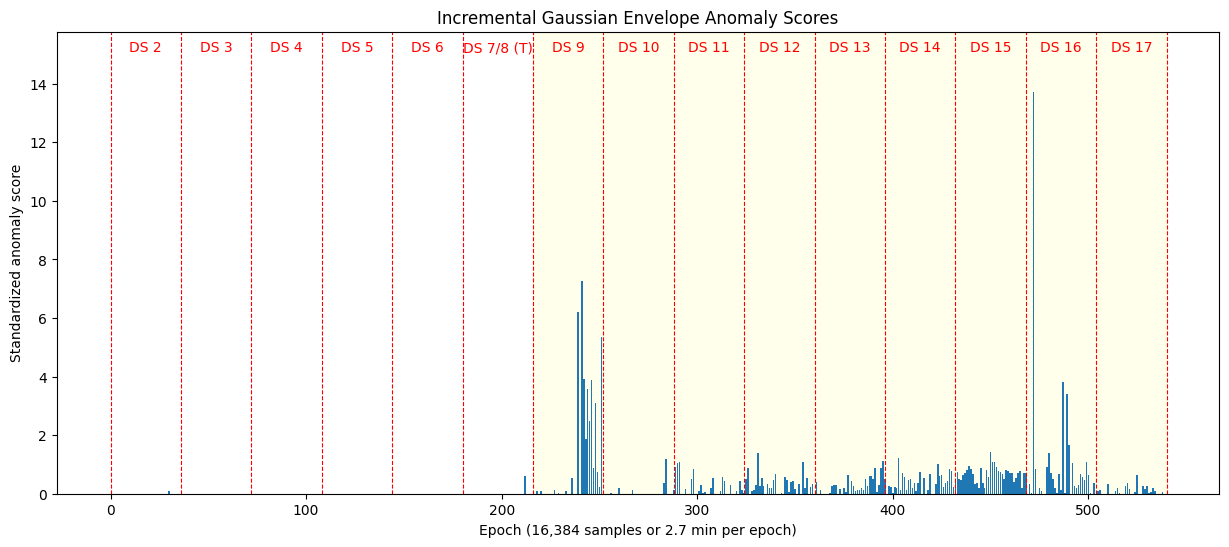

In [495]:
plot_anom(slg, "Incremental Gaussian Envelope Anomaly Scores")

### Online one class SVM

In [497]:
healthy_data_top_train.shape, damage_data_top.shape

((252, 3), (324, 3))

In [332]:
from sklearn.svm import OneClassSVM
from scipy.special import expit 

class IncrementalOneClassSVM:
    def __init__(self, buffer_size = 36, retrain_size=20):
        self.model = OneClassSVM(nu = 0.1, kernel='rbf')
        self.buffer_size = buffer_size
        self.retrain_size = retrain_size
        self.data_buffer = []
        self.support_vectors = None
        self.ctr = 0
        self.init_start = []
        np.random.seed(4)

    def initial_train(self, data):
        self.model.fit(data)
        self.support_vectors = self.model.support_vectors_

    def _buffer_data(self, new_data):
        self.data_buffer.extend(new_data)
        if self.ctr < 36:
            self.init_start.append(np.array(new_data).flatten())
            if self.ctr == 35:
                self.model.fit(np.array(self.init_start))
                self.support_vectors = self.model.support_vectors_

        elif len(self.data_buffer) > self.buffer_size:
            self._update_model()

    def _update_model(self):
        new_data = np.array(self.data_buffer)
        self.data_buffer = []

        # Filtering new data - select data significantly different from current support vectors
        # This is a simple distance-based filter for demonstration purposes
        distance = np.min(np.linalg.norm(new_data[:, np.newaxis] - self.support_vectors, axis=2), axis=1)
        significant_new_data = new_data[distance > np.percentile(distance, 50)]

        if len(significant_new_data) > 0:
            #combined_data = np.vstack([self.support_vectors, significant_new_data])
            print(f"Orig. nbr of support vectors of {self.support_vectors.shape[0]}")
            support_vector_entries = min(int(0.50 * self.retrain_size), self.support_vectors.shape[0])  # 20% from support vectors
            print(f"Sampled nbr of support vectors {support_vector_entries}") # show number of support vectors (usually around 10)
            new_data_entries = self.retrain_size - support_vector_entries  # remaining 80% from new data

            # Selecting entries
            selected_support_vectors = np.random.choice(self.support_vectors.shape[0], support_vector_entries, replace=False)
            selected_new_data = np.random.choice(significant_new_data.shape[0], new_data_entries, replace=False)

            # Retrain model with a subset of the data
            subset_for_retraining = np.vstack([self.support_vectors[selected_support_vectors], significant_new_data[selected_new_data]])

            self.model.fit(subset_for_retraining)
            self.support_vectors = self.model.support_vectors_

    def update(self, new_data):
        """
        Add new data for training. This can be a single data point or multiple data points in a batch.
        """
        if isinstance(new_data, list) or len(new_data.shape) > 1:
            self._buffer_data(new_data)
        else:
            self._buffer_data([new_data]) 
        self.ctr += 1

    def predict(self, data):
        """
        Predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        return self.model.predict(data)
    
    def predict_proba(self, data):
        """
        Pseudo-probabilistic predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        decision_function = self.model.decision_function(data)
        return 1-expit(decision_function)

In [333]:
slsvc = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM())
slsvc.loop()

Orig. nbr of support vectors of 11
Sampled nbr of support vectors 10
Orig. nbr of support vectors of 9
Sampled nbr of support vectors 9
Orig. nbr of support vectors of 8
Sampled nbr of support vectors 8
Orig. nbr of support vectors of 9
Sampled nbr of support vectors 9
Orig. nbr of support vectors of 9
Sampled nbr of support vectors 9
Orig. nbr of support vectors of 9
Sampled nbr of support vectors 9
Orig. nbr of support vectors of 9
Sampled nbr of support vectors 9


In [334]:
np.sum(np.array(slsvc.d_preds) < 0), np.sum(np.array(slsvc.h_preds) > 0), len(slsvc.d_preds), len(slsvc.h_preds)

(289, 248, 324, 288)

576


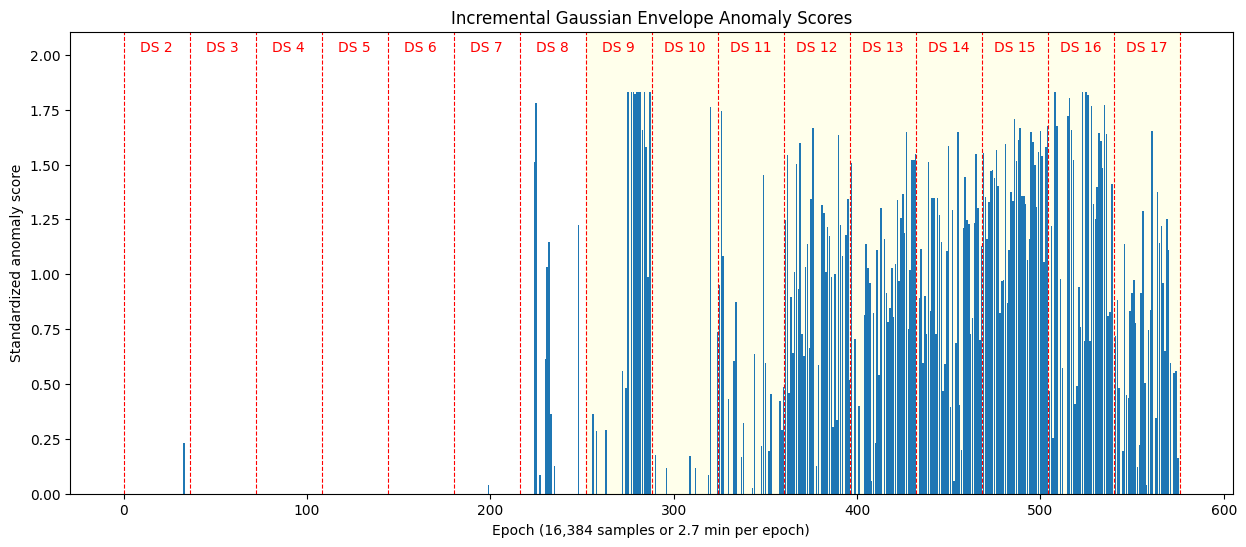

In [335]:
plot_anom(slsvc, "Incremental OCC-SVC Anomaly Scores")

### Half space trees

In [453]:
from river import compose
from river import datasets
from river import metrics
from river import preprocessing

class IncrementalHalfSpace():
    def __init__(self, h_len, size = 36, n_trees = 50, height  = 3):
        self.hst = compose.Pipeline(preprocessing.MinMaxScaler(), 
                                    anomaly.HalfSpaceTrees(n_trees=n_trees, height=height, window_size=size, seed=42))
        self.ctr = 0
        self.an_sc = [] # anomaly scores 
        self.h_len = h_len # number of healthy data points to expect 

    def update(self, data):
        data = {f'x_{i}': val  for i, val in enumerate(data)}
        self.ctr += 1
        self.hst = self.hst.learn_one(data)

    def predict_proba(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            if self.ctr < self.h_len:
                self.an_sc.append(sc) # to find if an anomaly is in fact anomalous, we must have a (running) distribution of anomalies
            return [sc]
        else:
            scores = []
            for el in data:
                inst = {f'x_{i}': val  for i, val in enumerate(el)}
                scores.append(self.hst.score_one(inst)) 
            return scores
        
    def predict(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            if np.std(self.an_sc) < np.abs(sc - np.mean(self.an_sc)):
                return [-1]
            else:
                return [1]
        else:
            scores = []
            mu = np.mean(self.an_sc)
            sigma = np.std(self.an_sc)
            for el in data:
                inst = {f'x_{i}': val for i, val in enumerate(el)}
                sc = self.hst.score_one(inst)
                if sigma < np.abs(sc - mu):
                    scores.append(-1)
                else:
                    scores.append(1)
            return scores

In [454]:
slhs = StreamLearning(healthy_data_top, damage_data_top, IncrementalHalfSpace(h_len = healthy_data_top.shape[0]))
slhs.loop()

eval dam
eval healthy


In [455]:
np.sum(np.array(slhs.d_preds) < 0), np.sum(np.array(slhs.h_preds) > 0), len(slhs.d_preds), len(slhs.h_preds)

(275, 254, 324, 288)

576


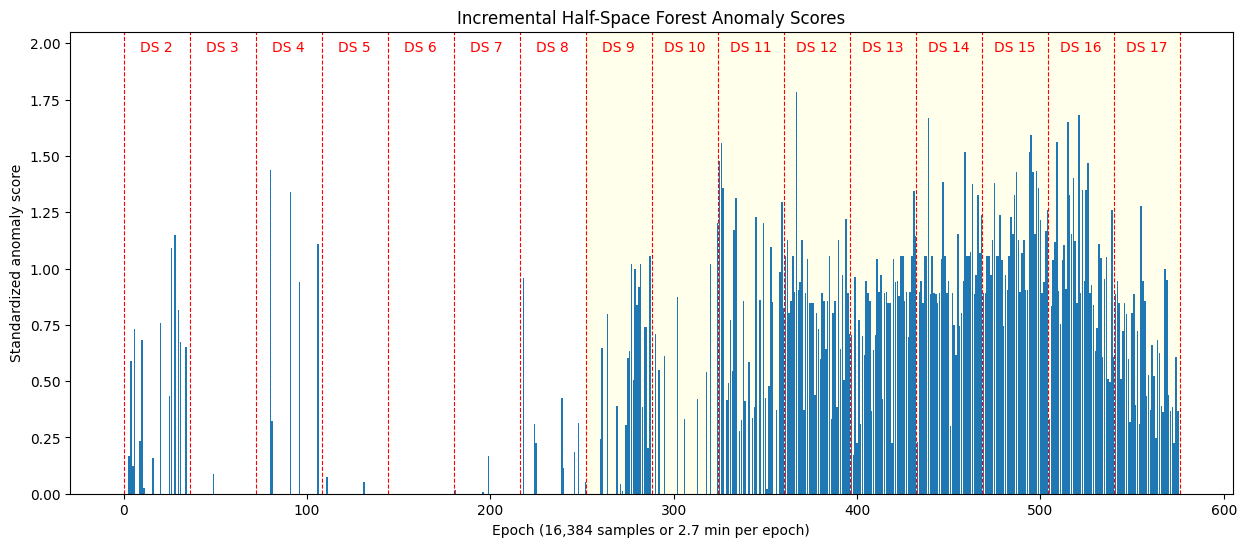

In [456]:
plot_anom(slhs, "Incremental Half-Space Forest Anomaly Scores")